# Structure of this document
### [1. Overview of the experiment](#cell1)  

### [2. Experiment Design](#cell2)
- [2.1 Metric Choice](#cell21)
- [2.2 Specify population](#cell22)
- [2.3 Meature Standard Deviation](#cell23)
- [2.4 Sizing](#cell24)
    - [2.4.1 Determine Number of Samples Total](#cell241)
    - [2.4.2 Determine Duration of experiment](#cell242)  

### [3. Experiment Analysis](#cell3)
- [3.1 Sanity Check](#cell31)
- [3.2 Check for Practical and Statistical Significance](#cell32)
- [3.3 Run Sign Tests](#cell33)
- [3.4 Recommendation](#cell34)
  - [3.4.1 Plot the daily data](#cell341)
  - [3.4.2 Break the data by weekday/weekends](#cell342)
  - [3.4.3 Additional ways to understand the experiment results](#cell343)
- [3.5 Conclusion](#cell35)
    
---

**Highlight of this work**
- Theoratically understand and explain of AB test, how to get sample size, click [here](#cell_understand) to see details.
- Recommendation and further possible analysis in [Section 3.4](#cell34)
- Potential improvements for this type of experiment in the future
  - Make sure enough data is collected, in this case Udacity should collected the past 14 days of enrollment and payment data as well.
  - Do some analysis(e.g., retrospecive analysis) to see if we need to specify a slice of population.
  - Consider run pre and post period AA test, especially considering the actual variability of evaluation metrics are much higher than the analytical variability. By doing pre period AA test, we'd be able to rule out the sources of variability caused by other unrelated factors.


<a id='cell1'></a>
## 1. Overview of the experiment
Full instructions [here](https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True) 

**Summary**  
Udacity, an online course platform, wants to test some change after users click "Start free trial".
- Control: Users go through the process and complete enrollment of free trial.
- Experiment: Users would be asked how long they'll commit to the course per week. If users answer less than 5 hours, a message pops up indicating that Udacity expects users to spend more than 5 hours per week. Then users are given two options—acknowledge the time expectation and continue enrollment, or choose to access materials for free.

Hypothesis of this experiment  
- This might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course.

Unit of diversion: Cookie  
- If the student enrolls in the free trial, they are tracked by user-id from that point forward. 
- The same user-id cannot enroll in the free trial twice. 
- For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

---

<a id='cell2'></a>
## 2. Experiment Design


<a id='cell21'></a>
### 2.1 Metric Choice

- **Invariant metrics**
  - Number of cookies  
    - That is, number of unique cookies to view the course overview page.
    - dmin = 3000
  - Number of clicks  
    - That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). 
    - dmin = 240
  - Click-through-probability  
    - That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. 
    - dmin = 0.01
  
- **Evaluation metrics**
  - Gross conversion  
    - That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. 
    - dmin = 0.01
  - Retention  
    - That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. 
    - dmin = 0.01
  - Net conversion  
    - That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. 
    - dmin = 0.0075  

_Notes:_
- _All practical significance boundaries(dmin) are given as absolute changes._
- _Any place "unique cookies" are mentioned, the uniqueness is determined by day._
- _User-ids are automatically unique since the site does not allow the same user-id to enroll twice._

---

**Explaination**
1. Given Unit of diversion is cookie, the number of cookies that view the course page should be randomized to assign to experiment/control group. Therefore it should be an invariant metric.
2. Given that the change happens after user click "Start free trial", the amount of cookies that click should also be invariant.
3. As for the metric *Number of user-ids*, because the user-id is not tracked in the experiment if the user does not enroll, the *Number of user-ids* would only record those who actually enroll. For enrollment the user will pass the different process between control and experiment, therefore it can't be used as an invariant metric.
4. *Click-through-probability* = *Number of clicks* / *Number of cookies*, therefore it's invariant.
5. I'd use *Net conversion* as the main evaluation metric, because the goal of the experiment is trying to recruit more users to keep using Udacity's service by helping users better understand the expectation of time commitment. Therefore, I expect the *Net conversion* would increase by the change of experiment.
6. *Gross conversion* and *Retention* is also helpful on evaluation because it breaks the one metric *Net conversion* into two stages, as *Net conversion* = *Gross conversion* * *Retention*. Based on the hypothesis, the *Gross conversion* might drop a bit but shouldn't be too much. And *Retention* should increase by some significant amount.
7. As we expect *Gross conversion* drops but hopefully not too much, in this case the practical significance boundary(dmin) to test should be revised to dmin = -0.01. And we hope that the result is not significant. If *Gross conversion* drops down too much, then we might want to consider if the users correctly receive/understand the message that Udacity wants to convey.

---

<a id='cell22'></a>
### 2.2 Specify population
It's not stated what population is chosen in this study in the instructions, but there're possibilities that some specific populations are much more influenced than others, e.g., there might be cultural differences of how many hours people like or can study per week.  

In this study where the slice information is unknown and not specified ahead, I think it'd be useful to check the difference of count, rate, distribution in control/experiment groups by different slices, e.g., age group, country etc. To make sure that (1) the differences shown in the evaluation metrics is not contributed by these differences and (2) if there's differences, possibly find out what slices are most influenced by the change.


<a id='cell23'></a>
### 2.3 Meature Standard Deviation
**Instructions**  
Given a sample size of 5000 cookies visiting the course overview page, calculate the analytical standard deviation based on values from this [spreadsheet](https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0).  

(In case the link became invalid in the future, I made a local copy and read from there.)

In [98]:
import pandas as pd
import numpy as np

from math import sqrt,factorial
from datetime import datetime
import plotly.express as px

from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Category10
from bokeh.models import WheelZoomTool,ResetTool,PanTool

output_notebook()

Loading BokehJS ...

In [5]:
df_baseline = pd.read_csv("Final Project Baseline Values - Sheet1.csv",header=None)
df_baseline

,0,1
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [80]:
# Calculate the probability based on the baseline values
p_click_through = df_baseline.iloc[1,1]/df_baseline.iloc[0,1]
p_gross_conversion = df_baseline.iloc[2,1]/df_baseline.iloc[1,1]
p_retention = df_baseline.iloc[5,1]
p_net_conversion = p_gross_conversion*p_retention

In [81]:
# Calculate the number of unit(the denominator) for each evaluation metric
n_cookies = 5000
n_click = n_cookies * p_click_through
n_enroll = n_click * p_gross_conversion

<a id='cell_std_analyticl'></a>
**Analysis**  
Given that this is a binomial distribution with the number of samples large enough to be treated as normal distribution, the formula to calculate the standard deviation is stdev = sqrt(p*(1-p)/N) where p is the probability and N is the number of unit(the denominator) for each evaluation metric

In [185]:
metric_list = ('gross_conversion','retention','net_conversion')
p_list = (p_gross_conversion,p_retention,p_net_conversion)

# initiate a dataframe to store the results
analytical_std = pd.DataFrame(columns=['Analytical standard deviation'], index=metric_list)

for m,p,n in zip(metric_list,p_list,(n_click,n_enroll,n_click)):
    stdev = sqrt(p*(1-p)/n)
    analytical_std.loc[m] = round(stdev,4)
analytical_std

,Analytical standard deviation
gross_conversion,0.0017
retention,0.0549
net_conversion,0.0013


**Analysis**  
The analytical estimate of standard deviation should be similar to the empiracal estimate of standard deviation for the 3 chosen evaluation metrics, since the unit of analysis and unit of diversion are both cookies.  
This analytical standard deviation is used later to estimate the required sample size for this experiment.

---

<a id='cell24'></a>
### 2.4 Sizing

<a id='cell241'></a>
#### 2.4.1 Determine Number of Samples Total

In [ ]:
# initiate a dataframe to store the sample size results, as I'll compare different methods
column_names = ["EvanMiller_online", "EvanMiller_formula", "HanshengWang_formula","py_statsmodels"]
sample_size_compare = pd.DataFrame(columns=column_names, index=metric_list)
sample_size_compare['EvanMiller_online'] = [np.nan,39115,27413]

In [180]:
# Use EvanMiller's calculation formula: https://www.evanmiller.org/ab-testing/sample-size.html
def get_sample_size_EvanMiller_formula(alpha,beta,p_baseline,dmin):
    """Sample size calculation try to be same as EvanMiller's.
    
    Input
        alpha: False positive/Type I error, percentage to reject the null hypothesis while it shouldn't be rejected.
        beta: False negative/Type II error, percentage to fail rejecting the null hypothesis while we should have.
        p_baseline: baseline percentage for the event.
        dmin: Practical significance level, absolute value.
    
    Output
        sample_size: Required sample size per each group. Might not be an integer.
    """
    from scipy.stats import norm
    from math import sqrt
    
    z_alpha2 = norm.ppf(1.0-alpha/2)
    z_beta = norm.ppf(1-beta)
    p_experiment = p_baseline+dmin
    stdev_alpha2 = sqrt(2*p_baseline*(1-p_baseline))
    stdev_beta = sqrt(p_baseline*(1-p_baseline)+p_experiment*(1-p_experiment))
    
    return ((z_alpha2*stdev_alpha2+z_beta*stdev_beta)/dmin)**2

In [181]:
alpha = 0.05
beta = 0.2
dmin_list = (-0.01,0.01,0.0075)

col = 'EvanMiller_formula'
for p,m,d in zip(p_list,metric_list,dmin_list):
    sample_size_compare.loc[m,col] = round(get_sample_size_EvanMiller_formula(alpha,beta,p,d),0)


In [182]:
def get_sample_size_HanshengWang_formula(alpha,beta,p_baseline,dmin,number_ratio = 1):
    """Sample size calculation formula come from below 'To understand the core of the AB test'.
    
    Input
        alpha: False positive/Type I error, percentage to reject the null hypothesis while it shouldn't be rejected.
        beta: False negative/Type II error, percentage to fail rejecting the null hypothesis while we should have.
        p_baseline: baseline percentage for the event.
        dmin: Practical significance level, absolute value.
        number_ratio: expected ratio of #control/#experiment.
    Output
        sample_size_control,sample_size_experiment: Required sample size for each group. Might not be an integer.
    """
    from scipy.stats import norm
    from math import sqrt
    
    z_alpha2 = norm.ppf(1.0-alpha/2)
    z_beta = norm.ppf(1-beta)
    p_experiment = p_baseline+dmin
    
    n2 = (z_alpha2+z_beta)**2*(p_baseline*(1-p_baseline)/number_ratio+p_experiment*(1-p_experiment))/dmin**2
    # If control and experiment are the same size, return only one number
    if number_ratio==1:
        return n2
    else:
        n1 = number_ratio * n2
        return n1,n2


In [183]:
col = 'HanshengWang_formula'
for p,m,d in zip(p_list,metric_list,dmin_list):
    sample_size_compare.loc[m,col] = round(get_sample_size_HanshengWang_formula(alpha,beta,p,d),0)


In [186]:
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize as es

col = 'py_statsmodels'
for p,m,d in zip(p_list,metric_list,dmin_list):
    sample_size_compare.loc[m,col] = round(zt_ind_solve_power(
        effect_size=es(prop1=p, prop2=p+d), alpha=alpha, power=1-beta, alternative="two-sided"),0)

# choose which number to use, explained in below analysis
sample_size_compare['chosen'] = sample_size_compare['EvanMiller_online']
sample_size_compare.loc[sample_size_compare['chosen'].isnull(),'chosen'] = sample_size_compare.loc[sample_size_compare['chosen'].isnull(),'HanshengWang_formula']
sample_size_compare


,EvanMiller_online,EvanMiller_formula,HanshengWang_formula,py_statsmodels,chosen
gross_conversion,NaN,25558,25230,25230,25230
retention,39115.0,39087,39048,39051,39115
net_conversion,27413.0,27413,27981,27978,27413


**Analysis**  
- I did some research and [this article](https://jeffshow.com/caculate-abtest-required-sample-size.html#comments) compared various methods from different websites/R/Python packages. The results are similar but with a bit difference, just as there're some differences in above table.
- HanshengWang_formula is explained [below](#cell_understand). In the future I will probably use this formula as I fully understand it and it makes sense. The other formulas lacks source to fully understand it.  
- For the purpose of submitting the results to Udacity, I'll use [EvanMiller's online calculator](https://www.evanmiller.org/ab-testing/sample-size.html)'s results for now.
- As for the 1st one, EvanMiller's online calculator doesn't enable negative dmin and I'm not sure if EvanMiller's calculator count negative change. Therefore for the first one I'll just use HanshengWang_formula calculation. 
---

<a id='cell_understand' ></a>
**HanshengWang_formula Explained**  
**_This is also important to understand the core of AB test_**
- Assume the true probability for control, experiment group is p1,p2, and the estimate probability from the samples for control, experiment group is p1_hat, p2_hat.  
- As p1_hat and p2_hat are the un-biased estimate of p1 and p2, therefore p1_hat - p2_hat is the unbiased estimate of p1-p2.(I think this is because of the central limit theory)  
- One last assumption is that the samples are IID(Independent and Identically Distributed), therefore Var(p1-p2) = Var(p1)+Var(p2).  
- Let stdev_p1p2 denotes (p1_hat * (1-p1_hat)/N1+p2_hat * (1-p2_hat)/N2)
With those above, the significance test for whether p1-p2 is 0 would be |(p1_hat-p2_hat)/stdev_p1p2|>z_alpha_div2.  

For the power test(for the purpose of calculating sample size), if the alternative hypothesis is True(meaning there is difference between p1 and p2), then we'd want |(p1_hat-p2_hat)/stdev_p1p2| >= z_alpha_div2+z_beta, where both z_alpha_div2 and z_beta means the positive z values here.  

See below image to help understanding, basicly we want the area of the integral of blue line till the red dash line(which is beta) to be small, here the threshold is 20%. If the blue dash line(|(p1_hat-p2_hat)/stdev_p1p2|) is far right then it definitely satisfy the requirement.

<img src="files/significance and power explain.png" style="width: 400px;">

Therefore, n1 = k * n2, n2 = (z_alpha_div2+z_beta)^2 * stdev_p1p2^2/(p1-p2)^2, this is implemented by the function *get_sample_size_HanshengWang_formula*

Source: Hansheng Wang and Shein-Chung Chow, Sample Size Calculation for Comparing Proportions, 3.1 Test for Equality

In [190]:
## Transform the unit back to number of cookies that view the course based on each metric's unit of analysis
sample_size_compare['chosen_pageviews'] = 0

for m in metric_list:
    denominator = p_click_through
    if m == 'retention':
        denominator *= p_gross_conversion
    sample_size_compare.loc[m,'chosen_pageviews'] = int(round(sample_size_compare.loc[m,'chosen']*2/denominator,0))

sample_size_compare['least_num_days'] = round(sample_size_compare['chosen_pageviews']/df_baseline.iloc[0,1],0)
sample_size_compare

,EvanMiller_online,EvanMiller_formula,HanshengWang_formula,py_statsmodels,chosen,chosen_pageviews,least_num_days
gross_conversion,NaN,25558,25230,25230,25230,630750,16.0
retention,39115.0,39087,39048,39051,39115,4741212,119.0
net_conversion,27413.0,27413,27981,27978,27413,685325,17.0


<a id='cell242'></a>
#### 2.4.2 Determine Duration of experiment

**Analysis**  
- Determine theoratical range of #days
  - Assume we use 100% of traffic, the number of days that required to test *retention* is 119 days. This seems too long, considering the risk of the experiment.  
  - Therefore, I choose the metrics of net conversion and gross conversion and use the #cookies = 685325 instead. In this case, assume 100% traffic, #days = 17 days. This seems more reasonable.

- Analyze the risk of the experiment
  - As the change would possibly result in change of #users that use Udacity services, I don't think it's a good idea to use a large percentage of users. Although the change intended for good reasons, the new process added more steps for users to go through to complete the enrollment, therefore it's possible to lose some users who are sensitive to the easiness of enrollment process. There're other possibilities un-anticipated in this process that may cause the drop of conversion rate. Therefore I'd choose a percent of traffic no more than 60%.

- Other factors
  - On the other hand, the #cookies required is pretty large and this is the only experiment I want to run(There could be other people want to run other experiment though).  

Therefore, based on above reasons I choose to use 60% of the traffic(so that 30% users would be exposed to the change).


**Instructions**  
Q: Will you use Bonferroni correction in the analysis phase?  
A: Since the two main metrics I chose are *Gross conversion* and *Net conversion* and they are correlated in this experiment, I'll not use Bonferroni correction as it might be too conservative.

In [206]:
select_metric_list = ("gross_conversion","net_conversion")

In [192]:
pct_traffic = 0.6
n_days = int(round(sample_size_compare.loc['net_conversion','chosen_pageviews']
                   /(df_baseline.iloc[0,1]*pct_traffic),0))
print(f"#days needed to run this experiment: {n_days} days")

#days needed to run this experiment: 29 days


**An alternative way to possibly reduce the #samples**
- Specify the population and therefore the effect would not be diluted and might be easier to detect.  
  - E.g., Assume we know if the user/cookie is a student or working professional, and assume that students have more available time and better sense of the time commitment of a course, then maybe by specifying the population to be working professionals, the result of experiment might show clearer difference of improving conversion for working professionals.

<a id='cell3'></a>
## 3. Experiment Analysis
**Instructions**  
Data available [here](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0)

Explaination for the meaning of each column:

- Pageviews: Number of unique cookies to view the course overview page that day.
- Clicks: Number of unique cookies to click the course overview page that day.
- Enrollments: Number of user-ids to enroll in the free trial that day.
- Payments: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)

(In case the link became invalid in the future, I made a local copy and read from there.)  

---

Question about the data: 
- Why Udacity didn't collect the enroll data? It should be as the same day as click, not as same as payment date.
- If Udacity didn't collect the payment data for the last 14 days, wouldn't this be inadequate of sample size as how we designed the experiment?

In [25]:
df_control = pd.read_excel("Final Project Results.xlsx",sheet_name="Control")
print(df_control.dtypes)
df_control.head(3)

Date            object
Pageviews        int64
Clicks           int64
Enrollments    float64
Payments       float64
dtype: object


,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0


In [26]:
df_experiment = pd.read_excel("Final Project Results.xlsx",sheet_name="Experiment")
print(df_experiment.dtypes)
df_experiment.head(3)

Date            object
Pageviews        int64
Clicks           int64
Enrollments    float64
Payments       float64
dtype: object


,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0


<a id='cell31'></a>
#### 3.1 Sanity Check

In [194]:
# Check the amount of cookies collected in the experiment
col_name = 'Pageviews'
print(f"Pageviews all: {df_control[col_name].sum()+df_experiment[col_name].sum()}")
print(f"Pageviews effective: {df_control.loc[~df_control['Payments'].isnull(),col_name].sum()+df_experiment.loc[~df_experiment['Payments'].isnull(),col_name].sum()}")


Pageviews all: 690203
Pageviews effective: 423525


**Analysis**  
- The number of pageview all is similar to the number of what we expected to test "net conversion". 
- Theoratically though, as the data does not include enrollment and payment data for the last 14 days, the effective size of Pageviews, clicks should also be removing the last 14 days. But just to assume that all required data is correctly collected, here I'll use the total count to test those invariant metrics.

As we intended to assign same/similar amount of cookies to control/experiment, the probability that a cookie is assigned to control p = 0.5. This is a binomial distribution with number of samples large enough to be considered normal distribution.

In [195]:
def check_count_similar(count_control,count_experiment,p_control=0.5):
    """
    Sanity check on whether the count of invariant metric stay similar.
    Using alpha = 0.05(z = 1.96)
    
    Output
        pct_control
        confidence_interval_left
        confidence_interval_right
        whether pct_control in confidence interval
    """
    stdev_n_cookies = sqrt(p_control*(1-p_control)/(count_control+count_experiment))
    CI_cookies_left = p_control - 1.96*stdev_n_cookies
    CI_cookies_right = p_control + 1.96*stdev_n_cookies

    pct_control = count_control/(count_control+count_experiment)

    return round(pct_control,4),round(CI_cookies_left,4),round(CI_cookies_right,4),CI_cookies_left <= pct_control <= CI_cookies_right


In [204]:
# Initiate a dataframe to store the result
invar_list = ('Pageviews','Clicks','Click_through_probability')
column_names = ["pct_or_diff", "CI_left", "CI_right","is_invariant","Test_description"]
invariant_check = pd.DataFrame(columns=column_names, index=invar_list)

for col_name in invar_list[:-1]:
    invariant_check.loc[col_name,column_names[:-1]] = check_count_similar(df_control[col_name].sum(),df_experiment[col_name].sum())
invariant_check[column_names[-1]] = 'Whether pct in CI'


---
#### Empiracal way of checking whether Click-through-probability(CTP) is similar(Not in use)

<AxesSubplot:>

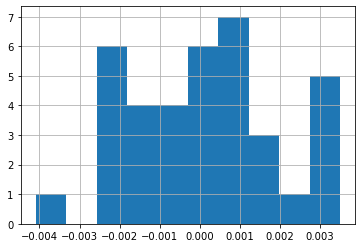

In [35]:
# Start by checking the distribution of CTP differences
df_control['CTP'] = df_control['Clicks']/df_control['Pageviews']
df_experiment['CTP'] = df_experiment['Clicks']/df_experiment['Pageviews']
diff_CTP = df_experiment['CTP'] - df_control['CTP']

diff_CTP.hist()
# Looks kind of like normal distribution

In [33]:
# Start to calculate CI and compare
mean_diff = diff_CTP.mean()
# Here I'm using the empiracal standard deviation so it's different from the analytical pooled method
stdev_diff = diff_CTP.std()
CI_diff_left = mean_diff - 1.96 * stdev_diff
CI_diff_right = mean_diff + 1.96 * stdev_diff
print(f"Whether 0 is in [{round(CI_diff_left,4)},{round(CI_diff_right,4)}]: {CI_diff_left <= 0 <= CI_diff_right}")

Whether 0 is in [-0.0036,0.0037]: True


This empiracal way gets a higher standard deviation than the analytical way below.

Question:  
Why don't we use the empiracal standard deviation(which is higher) but use the analytical pooled std?  
- My guess is that theoratically they should be similar, so it does not matter that much which to use.  
- However, that's based on the assumption that each individual cookie has same probability of click/enroll/retention, which might not be that strong, and cookies might not be IID.

---

In [202]:
def test_significance(x_control,n_control,x_experiment,n_experiment,dmin):
    """
    Test the practical and statistical significance.
    This is similar to the formula we talked about earlier when analyzing HanshengWang_formula,
    Except here the null hypothesis is p_control = p_experiment and therefore = p_pool
    
    Input
        All are counts except dmin
        dmin is the practical significance boundary
    Output
        The difference of the rates between experiment and control group
        confidence_interval_left
        confidence_interval_right
        whether 0 is in the confidence interval
        If dmin != 0, get one more return as whether dmin is in the confidence interval

    """
    p_pool = (x_control + x_experiment)/(n_control + n_experiment)
    stdev_pool = sqrt(p_pool*(1-p_pool)*(1/n_control+1/n_experiment))
    diff = x_experiment/n_experiment - x_control/n_control

    CI_left = diff - 1.96*stdev_pool
    CI_right = diff + 1.96*stdev_pool
    if dmin == 0:
        return round(diff,4),round(CI_left,4),round(CI_right,4),CI_left <= 0 <= CI_right
    else:
        return round(diff,4),round(CI_left,4),round(CI_right,4),CI_left <= 0 <= CI_right, CI_left <= dmin <= CI_right


In [205]:
col_name = invar_list[-1]
invariant_check.loc[col_name,column_names[:-1]] = test_significance(df_control['Clicks'].sum(),df_control['Pageviews'].sum(),df_experiment['Clicks'].sum(),df_experiment['Pageviews'].sum(),0)
invariant_check.loc[col_name,column_names[-1]] = 'Whether 0 in CI'
invariant_check


,pct_or_diff,CI_left,CI_right,is_invariant,Test_description
Pageviews,0.5006,0.4988,0.5012,True,Whether pct in CI
Clicks,0.5005,0.4959,0.5041,True,Whether pct in CI
Click_through_probability,0.0001,-0.0012,0.0014,True,Whether 0 in CI


**Analysis**  
As all three chosen invariant metrics are in the confidence interval, therefore there're no significant difference of the three metrics between control and experiment group.

---

<a id='cell32'></a>
#### 3.2 Check for Practical and Statistical Significance

In [207]:
# Initialize a dataframe to store the results
column_names = ["dmin","diff", "CI_left", "CI_right","is_0_in_CI","is_dmin_in_CI"]
evaluation_test = pd.DataFrame(columns=column_names, index=select_metric_list)

# make sure that #clicks is only using data not including last 14 days
# Because #Payments data don't have the last 14 days data
n_click_control = df_control.loc[~df_control['Payments'].isnull(),'Clicks'].sum()
n_click_experiment = df_experiment.loc[~df_experiment['Payments'].isnull(),'Clicks'].sum()
n_payment_control = df_control['Payments'].sum()
n_payment_experiment = df_experiment['Payments'].sum()
n_enroll_control = df_control['Enrollments'].sum()
n_enroll_experiment = df_experiment['Enrollments'].sum()

# Evaluation metrics test
m = select_metric_list[0]
evaluation_test.loc[m,column_names[0]] = -0.01
evaluation_test.loc[m,column_names[1:]] = test_significance(n_enroll_control,n_click_control,n_enroll_experiment,n_click_experiment,-0.01)

m = select_metric_list[1]
evaluation_test.loc[m,column_names[0]] = 0.0075
evaluation_test.loc[m,column_names[1:]] = test_significance(n_payment_control,n_click_control,n_payment_experiment,n_click_experiment,0.0075)

evaluation_test

,dmin,diff,CI_left,CI_right,is_0_in_CI,is_dmin_in_CI
gross_conversion,-0.01,-0.0206,-0.0291,-0.012,False,False
net_conversion,0.0075,-0.0049,-0.0116,0.0019,True,False


**Analysis**  
- This is showing that the difference of net_conversion between control and experiment group are not statitically different from 0.   
- And the difference is statistically different from practical significance level, but on the negative side, meaning we're 95% confident that the experiment change will not achieve the 0.75% positive change on net conversion.
- For retention, the tests show statistically significance from 0 and statistically different from practical significance level, on the negative size, meaning the change is reducing the gross conversion rate significantly, which is what we don't want.

Based on this, we definitely don't want to launch the change, at least not yet. We'll explore more on the experiment results in [3.4 Recommendation](#cell34)

<a id='cell33'></a>
#### 3.3 Run Sign Tests

In [138]:
def sign_test(n:int,k:int,n_tail:int = 2):
    """
    Run sign test for n choose k with p = 0.5
    
    Input
        n: positive integer, total number of items to choose from
        k: non-negative integer, number of items to be chosen, k<=n
        n_tail: can only be value of 1 or 2, where 2 means 'two-tail' test and 1 means 'one-tail' test
    Output
        Significance value of whether the case is happened by chance, range(0,1].
        If the value < 0.05, then we can say we're 95% confident that this is not happening by chance.
    """
    # validating the inputs
    if not (isinstance(n,int) and isinstance(k,int),isinstance(n_tail,int)):
        raise TypeError("All inputs must be integers.")
    if not (n>0 and k>=0 and n_tail in (1,2)):
        raise ValueError("Make sure the input values is in the definition range.")
    if n<k:
        raise ValueError("n has to be larger or equal than k.")
    
    p=0.5
    s = 0
    k = min(k,n-k)
    for kt in range(1,k+1):
        s += (factorial(n)/(factorial(kt)*factorial(n-kt)))
    
    return min(s*p**n*n_tail,1) # can use p^n because p = 0.5, otherwise it should be accumulated on p^k*(1-p)^(n-k)

In [67]:
for d in (df_control,df_experiment):
    d['gross_conversion'] = d['Enrollments']/d['Clicks']
    d['retention'] = d['Payments']/d['Enrollments']
    d['net_conversion'] = d['Payments']/d['Clicks']
df_control.head(3)

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,net_conversion,day_of_week,gross_conversion,retention
0,"Sat, Oct 11",7723,687,134.0,70.0,0.088955,0.101892,Sat,0.195051,0.522388
1,"Sun, Oct 12",9102,779,147.0,70.0,0.085586,0.089859,Sun,0.188703,0.476190
2,"Mon, Oct 13",10511,909,167.0,95.0,0.086481,0.104510,Mon,0.183718,0.568862


In [165]:
# make sure to select data not including last 14 days, as net_conversion is null for the last 14 days
n = df_control[~df_control['net_conversion'].isnull()].shape[0]

for m in metric_list:
    if m != 'retention':
        k = (df_experiment[m]>df_control[m]).sum()
        print(f"Sign test for {m}, {n} choose {k}: {round(sign_test(n,k),4)}")

Sign test for gross_conversion, 23 choose 4: 0.0026
Sign test for net_conversion, 23 choose 10: 0.6776


In [219]:
# p = 0.5
# p_choose_k_from_n = p**k*(1-p)**(n-k)*(factorial(n)/(factorial(k)*factorial(n-k)))
# print(n,k,round(p_choose_k_from_n*2,4))

**Analysis**  

- The result shows that for gross conversion and net conversion, it is consistent with the earlier tests. 

---

Question:  
This test is the same result as in [this website](https://www.graphpad.com/quickcalcs/binomial1.cfm)   
But why using less or equal than k instead of using exact k?
- Answer: The sign test is basicly like a discrete version of distribution test. If we think of n being really large, e.g., 1000, then for example the probability of choosing exact 500 would still be very small(in fact if with approaches to infinity, this probability approaches 0). Therefore we're calculating the accumulated probability, just as the probability test.

<a id='cell34'></a>
#### 3.4 Recommendation

**Analysis**  
As per the analysis 
- Significance level of net_conversion shows the results from experiment group is not significantly different from in control group,  
- With 95% confidence we're sure that it would not achieve the practical significance boundary(which is 0.0075 in this experiment)
- Tests for gross_conversion shows that we're 95% confident that the change makes the gross conversion rate decreases, and more than the practical level(which is 0.01). This is not what we wanted when we made the hypothesis at the beginning of this study.
- Sign test result also agrees on that the significance test.

Therefore, I recommend not launching the change from the experiment.

---
However, to better understand why the result not achieving expected results and therefore possibly providing some guidance on future experiments, we can try the approaches below to take a more deep look at the data.

- Check if there're possibilities with any problems about the evaluation data
  - E.g., Are the evaluation metrics in the expected range of values
- Break down by weekday/weekend pattern
- Break down by other slices, see if there's pattern of users group difference
- Talk w Engineering team if any problems related to engineering

<a id='cell341'></a>
#### 3.4.1 Plot the daily data

In [74]:
df_control['type'] = 'control'
df_experiment['type'] = 'experiment'
df_concat = pd.concat([df_control,df_experiment])

## Since Oct 11, 2014 is Saturday, for convenience I'll process the date as in 2014
df_concat['date'] = df_concat['Date'].apply(lambda x: datetime.strptime(x.split(',')[1]+',2014', ' %b %d,%Y'))
df_concat.drop('Date',axis=1,inplace=True)
df_concat.head(2)

,Pageviews,Clicks,Enrollments,Payments,CTP,net_conversion,day_of_week,gross_conversion,retention,type,date
0,7723,687,134.0,70.0,0.088955,0.101892,Sat,0.195051,0.522388,control,2014-10-11
1,9102,779,147.0,70.0,0.085586,0.089859,Sun,0.188703,0.476190,control,2014-10-12


In [209]:
fig = px.line(df_concat[~df_concat['gross_conversion'].isnull()],x='date',y=['gross_conversion','retention','net_conversion'],line_dash = 'type')
fig.show()

**Analysis**  
From this plot we can see that 
- It seems that the gross conversion rate after Oct 23 is more volatile and higher versus before it's pretty flat and the values are lower, we'll test if there're outliers in the control group and if there is, see if there's any reasons(e.g., engineering problems) resulting in it.
- I'll also test whether there's outliers in net conversion.
- Retention seems extremely volatile, especially for experiment group(from 32% to 78%).


In [85]:
fig2 = px.line(df_concat,x='date',y=['Pageviews'],line_dash = 'type')
fig2.show()

In [87]:
fig3 = px.line(df_concat,x='date',y=['Clicks','Enrollments','Payments'],line_dash = 'type')
fig3.show()

**Analysis**  
The count chart seems normal, consistent with the sanity check earlier.

---

#### Calculate confidence interval of the rates and check if there's outliers
- For control group, I'll use the baseline value stated as earlier [here](#cell22).
- For experiment group, I'll use the average estimate probability. Because earlier test shows that gross conversion in experiment group is statistically different from the control group, therefore we can't use the baseline value of gross conversion for experiment group. For net conversion, there's no statistical difference so both are fine.

In [118]:
def get_CI(p,n_unit):
    """
    Get the Confidence Interval(CI) by probability and number of units.
    
    Input
        p: Probability of an event, binomial distribution
        n_unit: number of units
    Output
        CI_left,CI_right
    """
    moe = 1.96*sqrt(p*(1-p)/n_unit)
    return p - moe, p + moe

In [212]:
# Initiate a dataframe
col_names = ['CI_left_control','CI_right_control','CI_left_experiment','CI_right_experiment']
evaluation_analytical_CI = pd.DataFrame(columns = col_names,index = select_metric_list)

p_gross_conversion_experiment = n_enroll_experiment/n_click_experiment
p_net_conversion_experiment = n_payment_experiment/n_click_experiment

n_list = (n_click_control,n_enroll_control,n_click_control)
p2_list = (p_gross_conversion_experiment,p_net_conversion_experiment)
n2_list = (n_click_experiment,n_click_experiment)

for m,p,n in zip(metric_list,p_list,n_list):
    CI_left,CI_right = get_CI(p,n)
    evaluation_analytical_CI.loc[m,['CI_left_control','CI_right_control']] = round(CI_left,4),round(CI_right,4)
    df_concat.loc[df_concat['type']=='control',f'not_outlier_{m}'] = df_concat.loc[df_concat['type']=='control',m].apply(lambda x:(CI_left<=x<=CI_right))
for m,p,n in zip(select_metric_list,p2_list,n2_list):
    CI_left,CI_right = get_CI(p,n)
    evaluation_analytical_CI.loc[m,['CI_left_experiment','CI_right_experiment']] = round(CI_left,4),round(CI_right,4)
    df_concat.loc[df_concat['type']=='experiment',f'not_outlier_{m}'] = df_concat.loc[df_concat['type']=='control',m].apply(lambda x:(CI_left<=x<=CI_right))

evaluation_analytical_CI


,CI_left_control,CI_right_control,CI_left_experiment,CI_right_experiment
gross_conversion,0.2002,0.2123,0.1924,0.2043
net_conversion,0.1047,0.114,0.108,0.1174
retention,0.5141,0.5459,NaN,NaN


In [217]:
# Bokeh is easier to stack the plots compared to plotly
## Red triangle markers means outliers in control group and grey triangle markers means outliers in experiment group
cl = Category10[len(metric_list)]
col_x = 'date'

p = figure(plot_width=900, plot_height=400,x_axis_type='datetime',tools='hover')
for name, color in zip( metric_list,  cl[:len(metric_list)]):
    pt=p.line(col_x,name, line_width=2, color = color, alpha=0.8,
                muted_color=color, source=df_concat[df_concat['type']=='control']
              , muted_alpha=0.2,legend_label=name+',control')
    pt=p.line(col_x,name, line_width=2, color = color, alpha=0.8,
                muted_color=color, source=df_concat[df_concat['type']=='experiment']
              , muted_alpha=0.2,legend_label=name+',experiment',line_dash='dashed')


for t,color in zip(('control','experiment'),('red','grey')):
    for m in metric_list:
        if not(t=='experiment' and m == 'retention'):
            ps = p.scatter(x='date', y=m, source=df_concat[(df_concat['type']==t)&(df_concat[f'not_outlier_{m}']==False)]
                      , marker='triangle', size=11, line_color="navy", fill_color=color, alpha=0.5)

p.legend.border_line_width = 1.2
p.legend.border_line_color = "grey"
p.legend.background_fill_alpha = 0.5

p.legend.click_policy="mute"
p.add_tools(ResetTool(),WheelZoomTool(),PanTool())

show(p)

**Analysis**  
With red triangle markers showing outliers in the control group and grey markers show outliers in experiment group, we can see that
- Apparently there're a lot of 'outliers', in both control group and experiment group, meaning the value of evaluation metrics in the control group are different from the baseline value, and the values in experiment group are more volatile than its analytical variance.  
- One reason could be that the real/empiracal variance is actually higher than the analytical variance of these evaluation metrics.  
  - To find out whether it's the case stated above, we can do a retrospective analysis on historical data to see if the actual variance is higher.
  - If historical data is not available, then we can consider run pre/post period AA experiment.(Specifically in this case we can't run pre period AA experiment to check the variance but just mentioned here for future experiments.)
- If the historical data is not like this, we can consider
  - Talk with the engineering team, see if there's anything related that can possibly cause the difference. 
  - Any other events happening that might possibly influence this, e,g., anything happens after Oct 23 so that gross conversion rate is looks higher and more volatile.
  

<a id='cell342'></a>
#### 3.4.2 Break the data by weekday/weekends
Assume above problems solved, we can also check if there's any weekday/weekend pattern to help us understand more about the data.

In [50]:
df_control['day_of_week'] = df_control['Date'].apply(lambda x: x.split(',')[0])
print(df_control['day_of_week'].unique())

['Sat' 'Sun' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri']


In [51]:
df_experiment['day_of_week'] = df_experiment['Date'].apply(lambda x: x.split(',')[0])
print(df_experiment['day_of_week'].unique())

['Sat' 'Sun' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri']


In [65]:
# Run the sign test for weekday/weekends
weekday_list = ['Mon' ,'Tue', 'Wed', 'Thu', 'Fri']
k = (df_experiment.loc[df_experiment['day_of_week'].isin(weekday_list),'net_conversion']>df_control.loc[df_control['day_of_week'].isin(weekday_list),'net_conversion']).sum()
n = df_control[(df_control['day_of_week'].isin(weekday_list) & (~df_control['net_conversion'].isnull()))].shape[0]
print(f"Weekday: {n} choose {k}, p-value is {round(sign_test(n,k),4)}")

weekend_list = ['Sat','Sun']
k = (df_experiment.loc[df_experiment['day_of_week'].isin(weekend_list),'net_conversion']>df_control.loc[df_control['day_of_week'].isin(weekend_list),'net_conversion']).sum()
n = df_control[(df_control['day_of_week'].isin(weekend_list) & (~df_control['net_conversion'].isnull()))].shape[0]
print(f"Weekend: {n} choose {k}, p-value is {round(sign_test(n,k),4)}")

Weekday: 15 choose 6, p-value is 0.6072
Weekend: 8 choose 4, p-value is 1


**Analysis**  
Both p-values are not significant, so there's no weekday/weekend pattern in this experiment.

<a id='cell343'></a>
#### 3.4.3 Additional ways to understand the experiment results

- Break the data by other slices
  - Assume Udacity have additional data such as the demographics of the users participating in the experiment, or country, language, platform etc., we can do some analysis by slicing the experiment results to those different slices and check if there's any reason highly correlated to the results.  
  - If there're some slices that contribute highly positive to the evaluation metric, then we can talk with the decision maker based on the specified population group size that might be positively impacted, see if we want to perform further experiments.

- Conduct surveys on user experience for the experiment change  
Another thing we could do, again, depending on how much engineering cost or customer service cost, that is to run the experiment for a few more days and send surveys to those who quit enrolling in the control/experiment group, to gather information about their experience in the process.
  - E.g., maybe it's because there're more pages in the process and people thought there'll be even more questions, so they lost patience. In this case, for future experiment design, we should be carefully about adding process and clearly convey the message that it's just one question.
  - E.g., maybe it's because people don't like how the question is asked. In this case we could collect information on what would the users like better.
  - E.g., maybe it's because some people thought they have less than 5 hours per week but actually would be studying for more than 5 hours. In this case, by asking the question and directing the user to access the materials based on user's answer, Udacity loses those students.
  - E.g., maybe the button of continuing to enroll is not as obvious as the access to course material button etc...

---

<a id='cell35'></a>
### 3.5 Conclusion

- Per the analysis of significance level and practical significance level in [3.2](#cell32) and the sign test in [3.3](#cell33), I recommend not launching the change, at least not yet.
- The next step is to do more in-depth analysis and talk with engineering team, based on approaches in [3.4](#cell34) recommendation(summary items listed below)
  - Find out why the results have 'outliers', by retrospective analysis, pre/post period AA test, talk with engineering team, find out other possible events that may cause this. See if there're problems instead of the experiment change being non effective.
  - Slicing the data by different groups, e.g., platform/country/language/age groups etc. and see if any group show interesting pattern to explain the results.
  - (Optional) Send surveys to the cookies that quit enrolling in the experiment group to understand what aspect influence their decisions.
- After the steps above, we should be able to rule out the problems and understand the results better. We then can decide whether to do further experiments or just to completely abandon this experiment.